In [1]:
import os
import random
import numpy as np
import pandas as pd 
from skimage import io
from skimage import color
from PIL import Image
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
from dask.array.image import imread
from dask import bag, threaded
from dask.diagnostics import ProgressBar
import cv2
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")



import keras
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras.layers import Flatten,Dropout
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.preprocessing import image 
from keras.layers.normalization import BatchNormalization
from keras import optimizers


Using TensorFlow backend.


In [2]:
driver_details = pd.read_csv('/home/jupyter/driver_imgs_list.csv',na_values='na')
print(driver_details.head(5))


  subject classname            img
0    p002        c0  img_44733.jpg
1    p002        c0  img_72999.jpg
2    p002        c0  img_25094.jpg
3    p002        c0  img_69092.jpg
4    p002        c0  img_92629.jpg


In [3]:
## Getting all the images

train_image = []
image_label = []


for i in range(10):
    print('now we are in the folder C',i)
    imgs = os.listdir("/home/jupyter/TrainImages/train/c"+str(i))
    for j in range(len(imgs)):
    #for j in range(100):
        img_name = "/home/jupyter/TrainImages/train/c"+str(i)+"/"+imgs[j]
        img = cv2.imread(img_name)
        #img = color.rgb2gray(img)
        img = img[50:,120:-50]
        img = cv2.resize(img,(224,224))
        label = i
        driver = driver_details[driver_details['img'] == imgs[j]]['subject'].values[0]
        train_image.append([img,label,driver])
        image_label.append(i)



now we are in the folder C 0
now we are in the folder C 1
now we are in the folder C 2
now we are in the folder C 3
now we are in the folder C 4
now we are in the folder C 5
now we are in the folder C 6
now we are in the folder C 7
now we are in the folder C 8
now we are in the folder C 9


In [4]:
## Randomly shuffling the images

import random
random.shuffle(train_image)

In [5]:
## getting list of driver names

D = []
for features,labels,drivers in train_image:
    D.append(drivers)

## Deduplicating drivers

deduped = []

for i in D:
    if i not in deduped:
        deduped.append(i)
    

## selecting random drivers for the validation set
driv_selected = []
import random
driv_nums = random.sample(range(len(deduped)), 4)
for i in driv_nums:
    driv_selected.append(deduped[i])


In [6]:
## Splitting the train and test

X_train= []
y_train = []
X_test = []
y_test = []
D_train = []
D_test = []

for features,labels,drivers in train_image:
    if drivers in driv_selected:
        X_test.append(features)
        y_test.append(labels)
        D_test.append(drivers)
    
    else:
        X_train.append(features)
        y_train.append(labels)
        D_train.append(drivers)
    
print (len(X_train),len(X_test))
print (len(y_train),len(y_test))

18924 3500
18924 3500


In [7]:
## Converting images to nparray. Encoding the Y

X_train = np.array(X_train).reshape(-1,224,224,3)
X_test = np.array(X_test).reshape(-1,224,224,3)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)


print (X_train.shape)


(18924, 224, 224, 3)


In [8]:
## Defining the input

from keras.layers import Input
resnet50_input = Input(shape = (224, 224, 3), name = 'Image_input')

## The RESNET model

from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.applications.resnet50 import ResNet50


#Get the RESNET weights and layers

model_resnet50_conv = ResNet50(weights= 'imagenet', include_top=False, input_shape= (224,224,3))
model_resnet50_conv.summary()


Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________

In [9]:
#Use the generated model 
from keras.models import Model


output_resnet50_conv = model_resnet50_conv(resnet50_input)

#Add the fully-connected layers 

x = Flatten(name='flatten')(output_resnet50_conv)
# x = Dense(4096, activation='relu', name='fc1')(x)
# x = Dense(4096, activation='relu', name='fc2')(x)
x = Dense(10, activation='softmax', name='predictions')(x)


resnet50_pretrained = Model(input = resnet50_input, output = x)
# for layer in resnet50_pretrained.layers[:2]:
#     layer.trainable=False
# for layer in resnet50_pretrained.layers[2:]:
#     layer.trainable=True


resnet50_pretrained.summary()

# Compile CNN model
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8, decay=0.0)
sgd = optimizers.SGD(lr = 0.01)
resnet50_pretrained.compile(loss='categorical_crossentropy',optimizer = adam,metrics=['accuracy'])


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Image_input (InputLayer)     (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
predictions (Dense)          (None, 10)                1003530   
Total params: 24,591,242
Trainable params: 24,538,122
Non-trainable params: 53,120
_________________________________________________________________


In [10]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint,EarlyStopping

checkpointer = ModelCheckpoint('resnet_weights_aug_alltrained_adam.hdf5', verbose=1, save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss', patience=10, verbose=1)


datagen = ImageDataGenerator(
    height_shift_range=0.5,
    width_shift_range = 0.5,
    zoom_range = 0.5,
    rotation_range=30
        )
#datagen.fit(X_train)
data_generator = datagen.flow(X_train, y_train, batch_size = 64)

# Fits the model on batches with real-time data augmentation:
resnet50_model = resnet50_pretrained.fit_generator(data_generator,steps_per_epoch = len(X_train) / 64, callbacks=[checkpointer, earlystopper],
                                                            epochs = 25, verbose = 1, validation_data = (X_test, y_test))



Epoch 1/25
296/295 [==============================] - 224s 758ms/step - loss: 2.5154 - accuracy: 0.2069 - val_loss: 2.0128 - val_accuracy: 0.3837

Epoch 00001: val_loss improved from inf to 2.01283, saving model to resnet_weights_aug_alltrained_adam.hdf5
Epoch 2/25
296/295 [==============================] - 208s 702ms/step - loss: 1.3321 - accuracy: 0.5342 - val_loss: 1.4686 - val_accuracy: 0.7111

Epoch 00002: val_loss improved from 2.01283 to 1.46864, saving model to resnet_weights_aug_alltrained_adam.hdf5
Epoch 3/25
296/295 [==============================] - 207s 700ms/step - loss: 0.9623 - accuracy: 0.6658 - val_loss: 1.5796 - val_accuracy: 0.7389

Epoch 00003: val_loss did not improve from 1.46864
Epoch 4/25
296/295 [==============================] - 214s 722ms/step - loss: 0.7811 - accuracy: 0.7261 - val_loss: 2.0603 - val_accuracy: 0.5831

Epoch 00004: val_loss did not improve from 1.46864
Epoch 5/25
296/295 [==============================] - 215s 727ms/step - loss: 0.6745 - ac

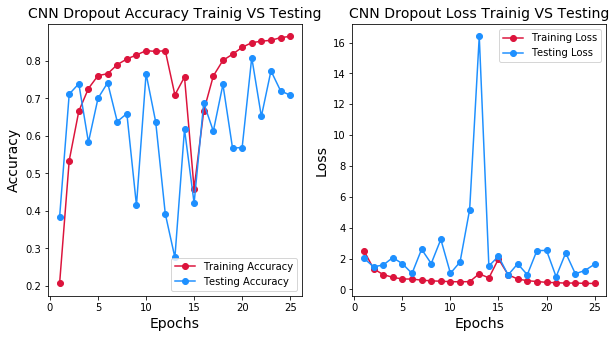

In [11]:
fig, axes = plt.subplots(1, 2, figsize = (10, 5))
axes[0].plot(range(1, len(resnet50_pretrained.history.history['accuracy']) + 1), resnet50_pretrained.history.history['accuracy'], linestyle = 'solid', marker = 'o', color = 'crimson', label = 'Training Accuracy')
axes[0].plot(range(1, len(resnet50_pretrained.history.history['val_accuracy']) + 1), resnet50_pretrained.history.history['val_accuracy'], linestyle = 'solid', marker = 'o', color = 'dodgerblue', label = 'Testing Accuracy')
axes[0].set_xlabel('Epochs', fontsize = 14)
axes[0].set_ylabel('Accuracy',fontsize = 14)
axes[0].set_title('CNN Dropout Accuracy Trainig VS Testing', fontsize = 14)
axes[0].legend(loc = 'best')
axes[1].plot(range(1, len(resnet50_pretrained.history.history['loss']) + 1), resnet50_pretrained.history.history['loss'], linestyle = 'solid', marker = 'o', color = 'crimson', label = 'Training Loss')
axes[1].plot(range(1, len(resnet50_pretrained.history.history['val_loss']) + 1), resnet50_pretrained.history.history['val_loss'], linestyle = 'solid', marker = 'o', color = 'dodgerblue', label = 'Testing Loss')
axes[1].set_xlabel('Epochs', fontsize = 14)
axes[1].set_ylabel('Loss',fontsize = 14)
axes[1].set_title('CNN Dropout Loss Trainig VS Testing', fontsize = 14)
axes[1].legend(loc = 'best')

Image number: 0
Image number: 1
Image number: 2
Image number: 3
Image number: 4
Image number: 5
Image number: 6
Image number: 7
Image number: 8
Image number: 9
Image number: 10
Image number: 11
Image number: 12
Image number: 13
Image number: 14
Image number: 15
Image number: 16
Image number: 17
Image number: 18
Image number: 19


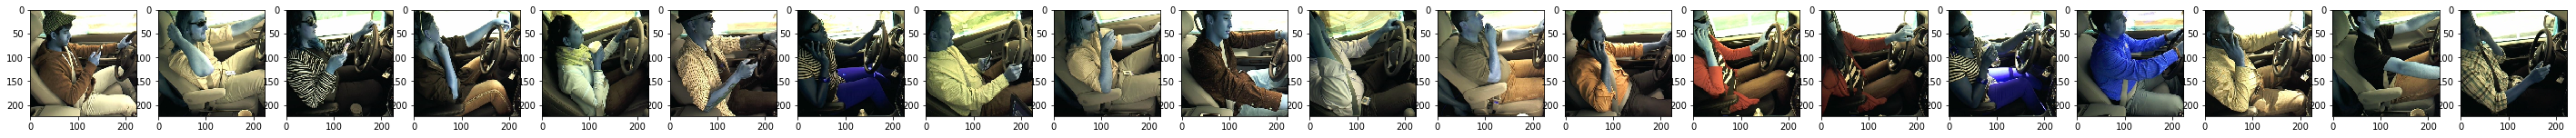

In [12]:
# labels is the image array
test_image = []
i = 0
fig, ax = plt.subplots(1, 20, figsize = (50,50 ))

files = os.listdir('/home/jupyter/TestImages')
nums = np.random.randint(low=1, high=len(files), size=20)
for i in range(20):
    print ('Image number:',i)
    img = cv2.imread('/home/jupyter/TestImages/'+files[nums[i]])
    #img = color.rgb2gray(img)
    img = img[50:,120:-50]
    img = cv2.resize(img,(224,224))
    test_image.append(img)
    ax[i].imshow(img,cmap = 'gray')
    plt.show


In [13]:
test = []

for img in test_image:
    test.append(img)
    
resnet50_pretrained.load_weights('resnet_weights_aug_alltrained_adam.hdf5')


test = np.array(test).reshape(-1,224,224,3)
prediction = resnet50_pretrained.predict(test)

In [15]:
prediction[0]

array([1.4612554e-05, 9.8044246e-01, 6.5783333e-06, 8.7194110e-07,
       2.1249309e-06, 4.6594109e-04, 1.7619392e-02, 1.0394464e-05,
       7.9471897e-04, 6.4283860e-04], dtype=float32)

In [16]:
tags = { "C0": "safe driving",
"C1": "texting - right",
"C2": "talking on the phone - right",
"C3": "texting - left",
"C4": "talking on the phone - left",
"C5": "operating the radio",
"C6": "drinking",
"C7": "reaching behind",
"C8": "hair and makeup",
"C9": "talking to passenger" }

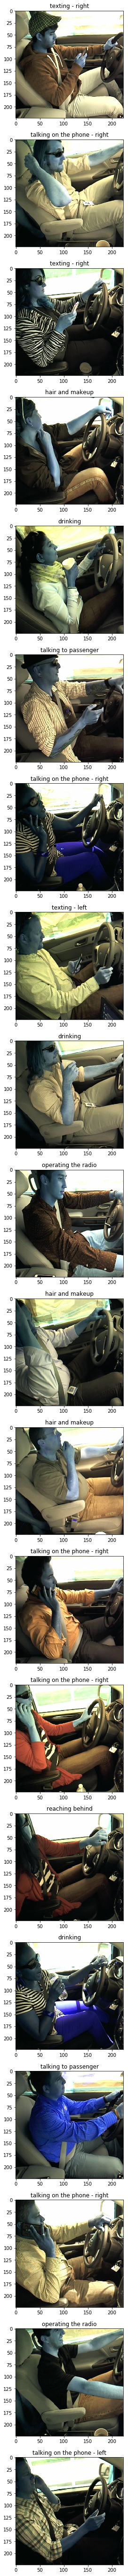

In [17]:
# labels is the image array
i = 0
fig, ax = plt.subplots(20, 1, figsize = (100,100))

for i in range(20):
    ax[i].imshow(test[i].squeeze())
    predicted_class = 'C'+str(np.where(prediction[i] == np.amax(prediction[i]))[0][0])
    ax[i].set_title(tags[predicted_class])
    plt.show
    
